<a href="https://colab.research.google.com/github/herusy/Machine_Learning/blob/main/%D0%93%D0%B5%D1%80%D1%83%D1%81_%D0%BF%D1%80_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Герус Я.О. ФІТ 4-8

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from kerastuner.tuners import RandomSearch

<ipython-input-3-5270575026c6>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
# Завантаження набору даних Fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("x_train original shape", x_train.shape)
print("y_train original shape", y_train.shape)

x_train = x_train / 255.0
x_test = x_test / 255.0

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train original shape (60000, 28, 28)
y_train original shape (60000,)


In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Flatten(input_shape=(28, 28)))

    for i in range(hp.Int('num_layers', 1, 4)):
      model.add(Dense(units=hp.Int('units_' + str(i), min_value=256, max_value=512, step=64), activation='relu'))
      model.add(BatchNormalization())
      model.add(Dropout(hp.Float('dropout_' + str(i), 0.2, 0.5, step=0.1)))

    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_logs',
    project_name='fashion_mnist_classification'
)

# Визначення ранньої зупинки та зниження швидкості навчання
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

tuner.search(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, reduce_lr])

# Отримання найкращої моделі
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

# Тренування та оцінка моделі
history = best_model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping, reduce_lr])

test_loss, test_acc = best_model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)


Trial 10 Complete [00h 02m 49s]
val_accuracy: 0.890999972820282

Best val_accuracy So Far: 0.8996000289916992
Total elapsed time: 00h 35m 07s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 384)                 │         301,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 384)                 │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 448)                 │         172,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 448)                 │           1,792 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           4,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 481,738 (1.84 MB)

 Trainable params: 480,074 (1.83 MB)

 Non-trainable params: 1,664 (6.50 KB)

Epoch 1/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8984 - loss: 0.2735 - val_accuracy: 0.8865 - val_loss: 0.3292 - learning_rate: 0.0010
Epoch 2/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8961 - loss: 0.2794 - val_accuracy: 0.8844 - val_loss: 0.3312 - learning_rate: 0.0010
Epoch 3/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8919 - loss: 0.2869 - val_accuracy: 0.8723 - val_loss: 0.3596 - learning_rate: 0.0010
Epoch 4/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8940 - loss: 0.2833 - val_accuracy: 0.8736 - val_loss: 0.3528 - learning_rate: 0.0010
Epoch 5/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8994 - loss: 0.2665 - val_accuracy: 0.8893 - val_loss: 0.3230 - learning_rate: 5.0000e-04
Epoch 6/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9057 - loss: 0.2548 - val_accuracy: 0.8868 - val_loss: 0.3213 - learning_rate: 5.0000e-04
Epoch 7/50
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Збереження моделі
model_save_path = '/content/drive/My Drive/fashion_mnist_best_model.h5'
best_model.save(model_save_path)


Mounted at /content/drive


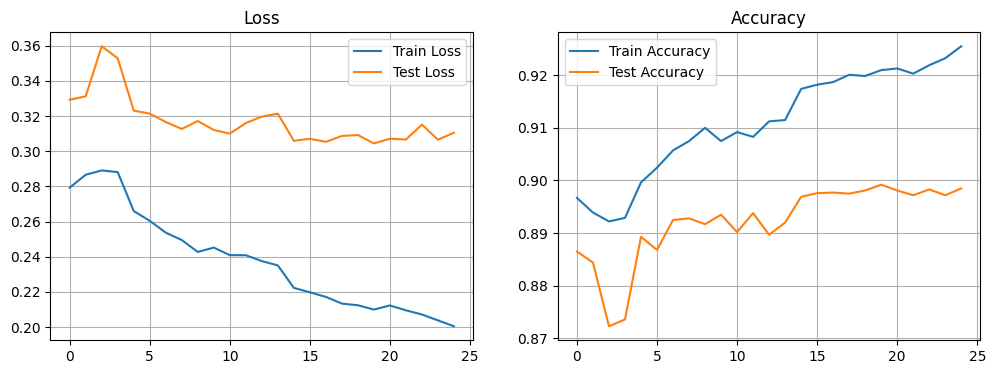

In [ ]:
import matplotlib.pyplot as plt

# 8. Побудова графіків функції втрат і точності
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.84      0.88      0.86      1000
     Trouser       0.99      0.97      0.98      1000
    Pullover       0.80      0.85      0.83      1000
       Dress       0.88      0.91      0.90      1000
        Coat       0.82      0.83      0.83      1000
      Sandal       0.98      0.97      0.97      1000
       Shirt       0.78      0.69      0.73      1000
     Sneaker       0.95      0.96      0.95      1000
         Bag       0.98      0.98      0.98      1000
  Ankle boot       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



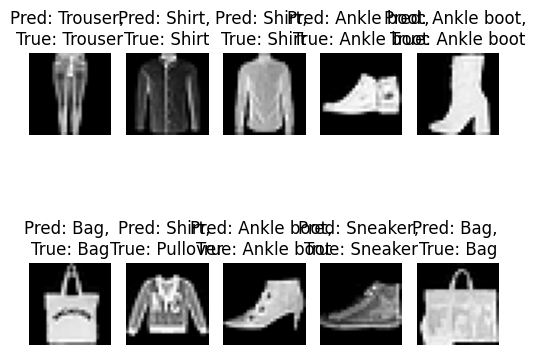

In [ ]:
# 9. Виведення класифікаційного звіту

from sklearn.metrics import classification_report
import numpy as np

class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes, target_names=class_labels))

num_samples = 10
indices = np.random.choice(len(x_test), num_samples, replace=False)

plt.figure(figsize=(5, 5))

for i, index in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[index].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {class_labels[y_pred_classes[index]]}, \nTrue: {class_labels[y_test[index]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


Висновок: застосування Keras Tuner привело до незначного підвищення точності, проте загальне покращення було невеликим. Основною перевагою Keras Tuner є автоматичний підбір архітектури, що спрощує процес налаштування параметрів, який вручну може бути досить складним.